<a href="https://colab.research.google.com/github/Alexandra0459/FinancialDataForecaster/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages
import pandas as pd
import numpy as np
# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline
# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
# The sharable link
link_AAPL = 'https://drive.google.com/open?id=1LRUTVAmzTut504ELhDOyrYZ5lAAL6ewI'
link_GOOG = 'https://drive.google.com/open?id=1a0TJKH0u9A_MNK6CB7jwtBVK6Tpb35tQ'
link_MSFT = 'https://drive.google.com/open?id=1PthG1N_bypoI1iS-_nB_w1GRdM-cY9VE'
fluff, id_AAPL = link_AAPL.split('=')
fluff, id_GOOG = link_GOOG.split('=')
fluff, id_MSFT = link_MSFT.split('=')
#print(id_AAPL,id_GOOG, id_MSFT)
# Store dataset into Pandas Dataframe
downloaded_AAPL = drive.CreateFile({'id':id_AAPL}) 
downloaded_AAPL.GetContentFile('AAPL.csv')  
df_AAPL = pd.read_csv('AAPL.csv')
downloaded_GOOG = drive.CreateFile({'id':id_GOOG}) 
downloaded_GOOG.GetContentFile('GOOG.csv')  
df_GOOG = pd.read_csv('GOOG.csv')
downloaded_MSFT = drive.CreateFile({'id':id_MSFT}) 
downloaded_MSFT.GetContentFile('MSFT.csv')  
df_MSFT = pd.read_csv('MSFT.csv')
df_MSFT.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-01,27.379999,27.389999,27.150000,27.200001,19.862570,75974500
1,2005-09-02,27.209999,27.270000,26.969999,27.020000,19.731119,52047500
2,2005-09-06,27.059999,27.290001,26.980000,27.000000,19.716515,46089000
3,2005-09-07,26.940001,27.110001,26.820000,26.850000,19.606977,44656100
4,2005-09-08,26.799999,26.879999,26.520000,26.610001,19.431717,52552300


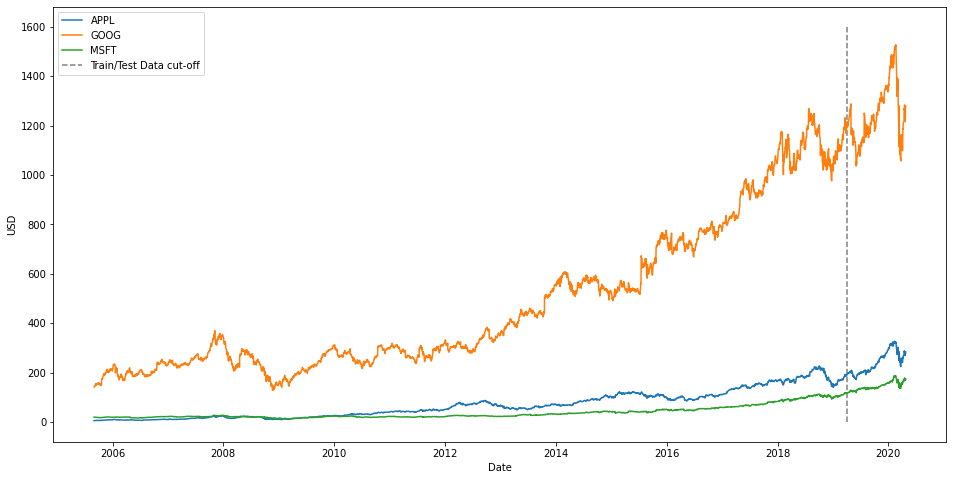

In [9]:
# Plot the stock prices
#setting index as date
import datetime
from pandas.plotting import register_matplotlib_converters
df_AAPL['Date'] = pd.to_datetime(df_AAPL.Date,format='%Y-%m-%d')
df_AAPL.index = df_AAPL['Date']
df_GOOG['Date'] = pd.to_datetime(df_GOOG.Date,format='%Y-%m-%d')
df_GOOG.index = df_GOOG['Date']
df_MSFT['Date'] = pd.to_datetime(df_MSFT.Date,format='%Y-%m-%d')
df_MSFT.index = df_MSFT['Date']
#plot
plt.figure(figsize=(16,8))
plt.plot(df_AAPL['Date'],df_AAPL['Adj Close'], label='APPL')
plt.plot(df_GOOG['Date'],df_GOOG['Adj Close'], label='GOOG')
plt.plot(df_MSFT['Date'],df_MSFT['Adj Close'], label='MSFT')
plt.vlines(datetime.date(2019,4,1),0,1600,linestyles='--',colors='gray',label='Train/Test Data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

In [10]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [0]:
#creating dataframe
data = df_AAPL.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_AAPL)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Adj Close'][i]
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
new_data.shape

(3686, 1)

In [0]:
#creating train and test sets 8140:9148
dataset = new_data.values
train = dataset[:3000,:]
valid = dataset[3000:,:]
#print(dataset)


3000


In [0]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
#scaled_data.shape
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [0]:
# create and fit the LSTM network
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
import numpy as np
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=2, verbose=2)
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

Epoch 1/5
 - 66s - loss: 3.1345e-04
Epoch 2/5
 - 64s - loss: 8.4646e-05
Epoch 3/5
 - 65s - loss: 6.7031e-05
Epoch 4/5
 - 65s - loss: 5.0907e-05
Epoch 5/5
 - 65s - loss: 4.1923e-05


Close          5.680297
Predictions    9.522724
dtype: float64

<bound method NDFrame.head of               Close
Date               
2005-09-01  5.73651
2005-09-02  5.73155
2005-09-06  6.05148
2005-09-07   6.0366
2005-09-08  6.17301
...             ...
2020-04-20   276.93
2020-04-21   268.37
2020-04-22    276.1
2020-04-23   275.03
2020-04-24   282.97

[3686 rows x 1 columns]>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


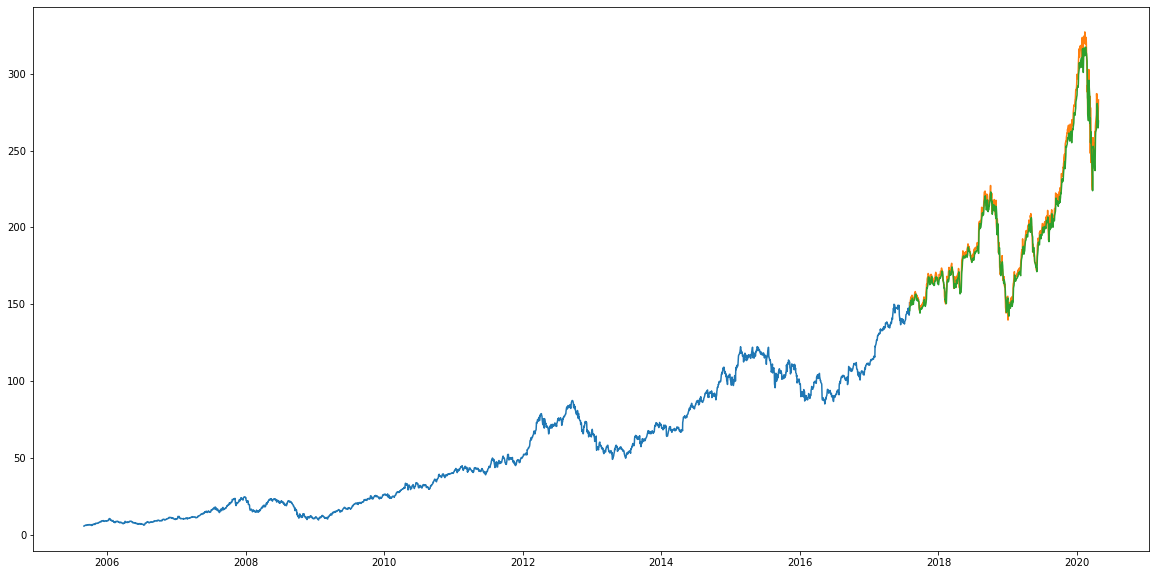

In [0]:
#for plotting
print(new_data.head)
train = new_data[:3000]
valid = new_data[3000:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])